In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '4'
os.environ['OPENBLAS_NUM_THREADS'] = '4'
os.environ['NUM_WORKERS'] = '4'
os.environ['MKL_NUM_THREADS'] = '4'
os.environ['NUMEXPR_NUM_THREADS'] = '4'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

import utils

/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
data_path = "/media/HlabShare/Gemechu_work/others"

In [4]:
df = pd.read_csv(f'{data_path}/window_analysis_tw_300_10_new.csv')
df = df[df.state!='REM']

In [5]:
df

,animal,block,subblock,window_index,condition,state,window_start_s,window_end_s,rho,chi,...,ang_sec_l2,spg_l2,eigvar_l2,eigent_l2,in_deg_l2,out_deg_l2,max_osc_growth2,avg_osc_growth2,avg_path2,avg_path_trad2
0,XYF03,1,0,0,dark,wake,0,300,0.055550,0.002142,...,0.000000,0.250907,0.006097,3.288537,0.326306,0.326306,0.014401,-0.027420,1.925813,80.587774
1,XYF03,1,0,1,dark,wake,148,448,0.063744,0.002108,...,0.000000,0.076384,0.002683,3.340736,0.191698,0.191698,0.014122,-0.021038,2.170213,95.204430
2,XYF03,1,0,2,dark,wake,296,596,0.068384,0.002032,...,0.000000,0.044928,0.001563,3.359637,0.119131,0.119131,0.006045,-0.013310,2.798734,129.047314
3,XYF03,1,0,3,dark,wake,444,744,0.069997,0.002292,...,0.000000,0.112251,0.001652,3.436489,0.150140,0.150140,0.020344,-0.020970,2.336287,109.295263
4,XYF03,1,0,4,dark,wake,592,892,0.075957,0.002541,...,0.000000,0.097666,0.001890,3.417169,0.161237,0.161237,0.024987,-0.015493,2.268946,103.654342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8461,XYF22,18,3,49,light,NREM,7252,7552,0.041171,0.001712,...,0.000000,0.332783,0.006720,3.007001,0.297649,0.297649,0.010485,-0.022187,1.873961,70.496255
8462,XYF22,18,3,53,light,NREM,7844,8144,0.037848,0.001653,...,0.000000,0.462616,0.008361,3.021553,0.343173,0.343173,0.014379,-0.027555,1.773826,64.645668
8463,XYF22,18,3,54,light,NREM,7992,8292,0.037869,0.001625,...,0.000000,0.400833,0.008089,2.992407,0.337870,0.337870,0.020684,-0.022972,1.798920,64.693827
8464,XYF22,18,3,65,light,NREM,9620,9920,0.045237,0.001796,...,3.141593,0.366561,0.006049,3.039931,0.281093,0.281093,0.020295,-0.023171,1.896122,70.739210


In [6]:
df.columns

Index(['animal', 'block', 'subblock', 'window_index', 'condition', 'state',
       'window_start_s', 'window_end_s', 'rho', 'chi', 'cv', 'br', 'maxe_l0',
       'sece_l0', 'ang_sec_l0', 'spg_l0', 'eigvar_l0', 'eigent_l0',
       'in_deg_l0', 'out_deg_l0', 'avg_path0', 'avg_path_trad0', 'maxe_l1',
       'ang_max_l1', 'sece_l1', 'ang_sec_l1', 'spg_l1', 'eigvar_l1',
       'eigent_l1', 'in_deg_l1', 'out_deg_l1', 'max_osc_growth1',
       'avg_osc_growth1', 'avg_path1', 'avg_path_trad1', 'maxe_l2',
       'ang_max_l2', 'sece_l2', 'ang_sec_l2', 'spg_l2', 'eigvar_l2',
       'eigent_l2', 'in_deg_l2', 'out_deg_l2', 'max_osc_growth2',
       'avg_osc_growth2', 'avg_path2', 'avg_path_trad2'],
      dtype='object')

In [7]:
summary_table = (
    df.groupby(['animal', 'block'])['subblock']
    .value_counts()
    .unstack(fill_value=0)
    .sort_index()
)
summary_table

subblock       0   1   2   3
animal block                
XYF03  1      66  54  71   0
       2      51  39  37   0
       3      54  45  58   0
       4      43  47  52   0
       5      45  55  65   0
       6      46  49  48   0
       7      65  41  66   0
XYF12  1      60  52  61   0
       2      61  52  51   0
       3      59  51  57   0
       4      70  65  62   0
       5      55  65  48   0
       6      75  51  47   0
       8      65  44  83   0
       11     48  47  49   0
       12     72  59  66   0
       13     49  53  57   0
       17     68  54  57   0
XYF13  1      73  56  58   0
       2      54  46  57   0
       5      66  56  48   0
       6      77  60  46   0
       7      60  65  58   0
XYF14  1      60  44  41   0
       2      58  63  59   0
       3      63  55  50   0
       4      57  59  56   0
       5      59  68  55   0
       6      59  52  60   0
       8      58  65  55   0
       11     42  56  43   0
       12     60  72  59   0
       13     46  52  40   0
       14     60  74  64   0
       16     55  66  56   0
       17     54  50  47   0
XYF22  4      50  47  43  47
       5      37  34  56  47
       6      46  57  33  47
       7      48  39  49  37
       8      53  64  48  49
       11     36  32  48  41
       12     55  51  31  40
       13     37  37  50  48
       14     47  47  40  26
       15     36  36  50  43
       16     50  66  31  24
       17     39  29  48  25
       18     32  54  40  39

### Use TimeSeriesMLProcessor to create moving window features
#### On each time step, columns of past time step features are added (as many as window_size)
#### Also statistics (mean, std etc) on the given window are calculated

In [8]:
processor = utils.TimeSeriesMLProcessor(df)
processed_df = processor.create_moving_windows(window_size=5, include_raw_windows=True)
processed_df

,animal,block,window_end_index,current_state,transition_type,transition_category,is_transition,previous_state,rho_t0,chi_t0,...,max_osc_growth2_max_consecutive_change,avg_osc_growth2_first_diff,avg_osc_growth2_slope,avg_osc_growth2_max_consecutive_change,avg_path2_first_diff,avg_path2_slope,avg_path2_max_consecutive_change,avg_path_trad2_first_diff,avg_path_trad2_slope,avg_path_trad2_max_consecutive_change
0,XYF03,1,4,wake,stay_wake,stay_wake,0,wake,0.055550,0.002142,...,0.014299,0.011928,0.002392,0.007728,0.343133,0.085234,0.628521,23.066568,6.022397,33.842884
1,XYF03,1,5,wake,stay_wake,stay_wake,0,wake,0.063744,0.002108,...,0.014781,0.007578,0.001297,0.007728,-0.081032,-0.069185,0.628521,-3.228937,-3.185085,33.842884
2,XYF03,1,6,wake,stay_wake,stay_wake,0,wake,0.068384,0.002032,...,0.036433,-0.005029,-0.000255,0.007660,-0.212320,-0.067175,0.497233,-7.422418,-3.216461,29.649403
3,XYF03,1,7,wake,stay_wake,stay_wake,0,wake,0.069997,0.002292,...,0.036433,-0.005050,-0.001295,0.007681,-0.016370,0.028473,0.497233,-7.927303,0.211595,29.649403
4,XYF03,1,8,wake,stay_wake,stay_wake,0,wake,0.075957,0.002541,...,0.036433,0.000260,-0.001204,0.010787,0.004747,0.024023,0.497233,-3.061144,0.327018,29.649403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8120,XYF22,18,160,NREM,stay_nrem,stay_nrem,0,NREM,0.054294,0.002262,...,0.066430,-0.003028,0.000268,0.010397,0.081788,0.022798,0.058736,10.038229,2.593403,6.707969
8121,XYF22,18,161,NREM,stay_nrem,stay_nrem,0,NREM,0.050544,0.002194,...,0.066430,-0.005341,-0.002105,0.010397,0.023005,0.012911,0.100135,6.017165,1.719411,6.707969
8122,XYF22,18,162,NREM,stay_nrem,stay_nrem,0,NREM,0.048383,0.001986,...,0.010463,-0.011155,-0.003639,0.008709,0.008062,-0.002528,0.100135,-0.642646,-0.112570,6.010181
8123,XYF22,18,163,NREM,stay_nrem,stay_nrem,0,NREM,0.046162,0.001946,...,0.010463,-0.009693,-0.002017,0.008709,0.080897,0.008675,0.100135,6.253136,0.670384,6.045383


   Training samples: 5985 (transitions: 10393, no-transitions: 223)
   Test samples: 2140 (transitions: 3639, no-transitions: 83)

[18:47:04] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


   Test Balanced Accuracy: 0.4255
   Test AUC: nan



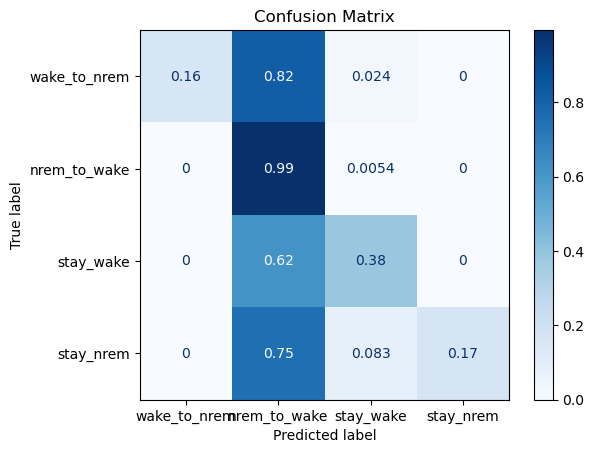

In [9]:
window_size=5
test_size=0.2
random_state=42
animal = None

split = processor.create_balanced_splits(
    split_type='inductive',
    label_type='multiclass',
    test_size=test_size,
    animal=animal,
    random_state=random_state,
    stratify=True
)

X_train, X_test = split['X_train'], split['X_test']
y_train, y_test = split['y_train'], split['y_test']

# Handle class imbalance - calculate scale_pos_weight
n_negative = (y_train == 0).sum()
n_positive = (y_train == 1).sum()
scale_pos_weight = n_negative / n_positive if n_positive > 0 else 1.0

# Train XGBoost model
# XGBoost parameters for classification
xgb_params = {
    'objective': 'multi:softmax',
    'eval_metric': 'logloss',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': scale_pos_weight,  # Handle class imbalance
    'random_state': random_state,
    'n_jobs': -1
}

# Create and train model
model = xgb.XGBClassifier(**xgb_params)

# Train with early stopping
model.fit(
    X_train, y_train,
    verbose=False
)


# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = balanced_accuracy_score(y_test, y_pred)
try:
    auc_score = roc_auc_score(y_test, y_pred_proba)
except ValueError:
    auc_score = np.nan  # Handle case where only one class in test set

print(f"   Test Balanced Accuracy: {accuracy:.4f}")
print(f"   Test AUC: {auc_score:.4f}")
print()


label_dict = {0:'wake_to_nrem', 1:'nrem_to_wake', 2:'stay_wake', 3:'stay_nrem'}
labels = sorted(label_dict.keys())
label_names = [label_dict[l] for l in labels]
# 'multiclass_raw': multiclass_labels,  # wake_to_nrem, nrem_to_wake, stay_wake, stay_nrem
# 'multiclass_encoded': multiclass_encoded,  # 0, 1, 2, 3

# Compute confusion matrix
#labels =  ['No Transition', 'Transition']
cm = confusion_matrix(y_test, y_pred, normalize='true', labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()



Top 20 Features by Importance:
                   Feature  Importance
141           in_deg_l1_t3    0.074343
142          out_deg_l1_t3    0.043591
346  out_deg_l1_first_diff    0.022741
218         eigent_l0_mean    0.022237
187             maxe_l2_t4    0.021337
195          out_deg_l2_t4    0.020768
385  out_deg_l2_first_diff    0.017712
147             maxe_l2_t3    0.015764
154           in_deg_l2_t3    0.014864
382   in_deg_l2_first_diff    0.014582
162                  cv_t4    0.013869
139           eigvar_l1_t3    0.013426
343   in_deg_l1_first_diff    0.013110
138              spg_l1_t3    0.012955
244        out_deg_l1_mean    0.012803
286          cv_first_diff    0.012684
177          ang_sec_l1_t4    0.011901
164             maxe_l0_t4    0.011743
178              spg_l1_t4    0.011640
222        out_deg_l0_mean    0.010856


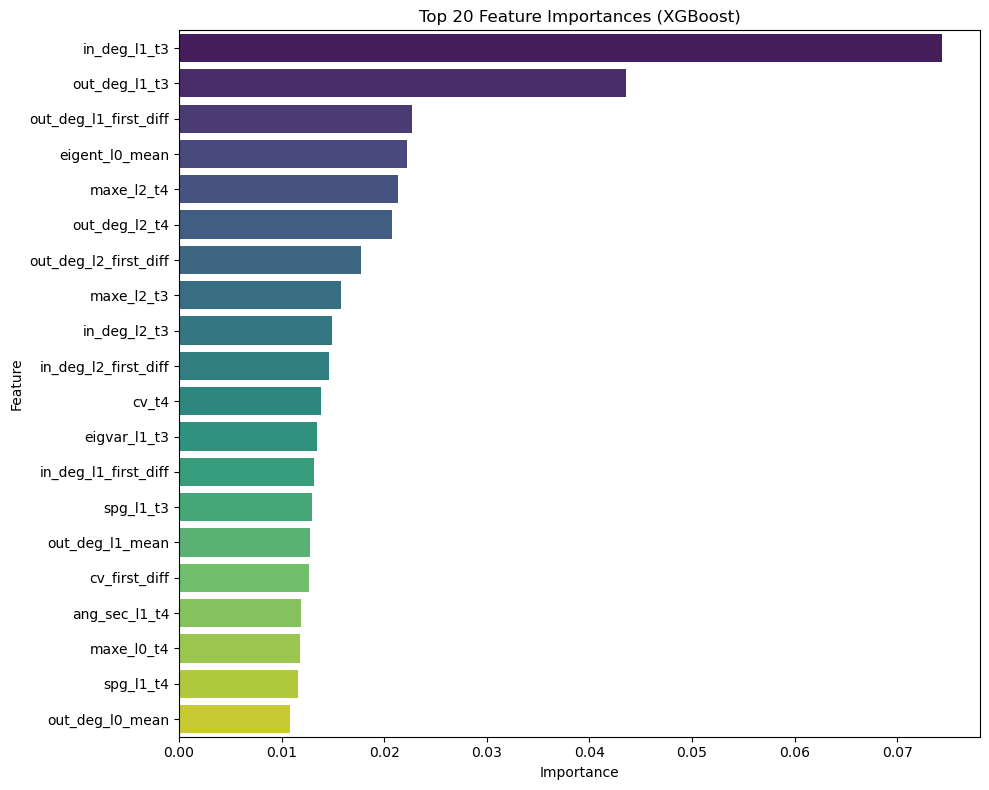

In [11]:
# Build dataframe of feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

# Show top features
print("\nTop 20 Features by Importance:")
print(feature_importance.head(20))

# Plot top 20
plt.figure(figsize=(10, 8))
sns.barplot(
    data=feature_importance.head(20),
    x='Importance',
    y='Feature',
    palette='viridis'
)
plt.title("Top 20 Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Hyperparameter optimization

### Simple random search

In [12]:
# make validation set from training set

rs = 42

train_df = processed_df.iloc[split['X_train'].index]

train_processor = utils.TimeSeriesMLProcessor(pd.DataFrame())

train_processor.processed_data = train_df

split = train_processor.create_balanced_splits(
    split_type='inductive',
    label_type='multiclass',
    test_size=test_size,
    animal=animal,
    random_state=random_state,
    stratify=True
)

X_train, X_valid = split['X_train'], split['X_test']
y_train, y_valid = split['y_train'], split['y_test']


from sklearn.model_selection import ParameterSampler

# Define search space (same as your param_grid)
param_grid = {
    'n_estimators': [20, 50, 100, 120, 150, 200, 250],
    'max_depth': [1, 2, 3, 4, 5, 6],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'scale_pos_weight': [1, 2, 3, 4, 5, 6, 7],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# Generate random samples of hyperparameters
n_iter = 50
param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=rs))

best_score = -np.inf
best_params = None
best_model = None

for params in param_list:
    model = xgb.XGBClassifier(
        objective = 'multi:softmax',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=rs,
        verbosity=0,
        nthread=5,
        **params
    )
    
    model.fit(X_train, y_train)
    
    # Evaluate on validation set
    y_pred = model.predict(X_valid)
    score = balanced_accuracy_score(y_valid, y_pred)
    
    if score > best_score:
        best_score = score
        best_params = params
        best_model = model

print("\nBest parameters:", best_params)
print("Best balanced accuracy on validation set: %.4f" % best_score)



/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/hlabhome/g.tolossa/.conda/envs/mlp_clas


Best parameters: {'subsample': 1.0, 'scale_pos_weight': 7, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Best balanced accuracy on validation set: 0.6352


### Testing with hyperparameters from simple random search

/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


   Test Balanced Accuracy: 0.3931
   Test AUC: nan



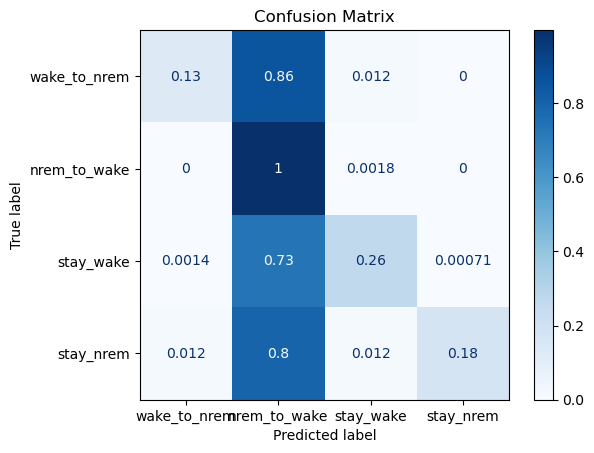

In [13]:
window_size=5
test_size=0.2
random_state=42
animal = None

split = processor.create_balanced_splits(
    split_type='inductive',
    label_type='multiclass',
    test_size=test_size,
    animal=animal,
    random_state=random_state,
    stratify=True
)

X_train, X_test = split['X_train'], split['X_test']
y_train, y_test = split['y_train'], split['y_test']

# Handle class imbalance - calculate scale_pos_weight
n_negative = (y_train == 0).sum()
n_positive = (y_train == 1).sum()
scale_pos_weight = n_negative / n_positive if n_positive > 0 else 1.0

# Train XGBoost model
# XGBoost parameters for classification
xgb_params = {
    'objective': 'multi:softmax',
    'eval_metric': 'logloss',
    'random_state': random_state,
    'nthread': 5,
    **best_params
}

# Create and train model
model = xgb.XGBClassifier(**xgb_params)

# Train with early stopping
model.fit(
    X_train, y_train,
    verbose=False
)


# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = balanced_accuracy_score(y_test, y_pred)
try:
    auc_score = roc_auc_score(y_test, y_pred_proba)
except ValueError:
    auc_score = np.nan  # Handle case where only one class in test set

print(f"   Test Balanced Accuracy: {accuracy:.4f}")
print(f"   Test AUC: {auc_score:.4f}")
print()


label_dict = {0:'wake_to_nrem', 1:'nrem_to_wake', 2:'stay_wake', 3:'stay_nrem'}
labels = sorted(label_dict.keys())
label_names = [label_dict[l] for l in labels]
# 'multiclass_raw': multiclass_labels,  # wake_to_nrem, nrem_to_wake, stay_wake, stay_nrem
# 'multiclass_encoded': multiclass_encoded,  # 0, 1, 2, 3

# Compute confusion matrix
#labels =  ['No Transition', 'Transition']
cm = confusion_matrix(y_test, y_pred, normalize='true', labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


### Sklearn random hyperparameter search

In [14]:
# Create scorer
scorer = make_scorer(balanced_accuracy_score)

# Create base model
base_model = xgb.XGBClassifier(
    objective = 'multi:softmax',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=rs,
    nthread = 5,
    verbosity=0
)

rs = 42
split = train_processor.create_balanced_splits(
    split_type='inductive',
    label_type='multiclass',
    test_size=test_size,
    animal=animal,
    random_state=random_state,
    stratify=True
)

X_train, X_valid = split['X_train'], split['X_test']
y_train, y_valid = split['y_train'], split['y_test']

# Create a predefined split to use your exact train/validation split
# Mark training samples as -1 and validation samples as 0
X_combined = np.vstack([X_train, X_valid])
y_combined = np.hstack([y_train, y_valid])
test_fold = np.hstack([np.full(len(X_train), -1), np.zeros(len(X_valid))])

ps = PredefinedSplit(test_fold)
n_iter = 100
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=n_iter,
    scoring=scorer,
    cv=ps,  # Use your predefined split
    random_state=rs,
)

random_search.fit(X_combined, y_combined)

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None...
                                           subsample=None, tree_method=None,
                                           use_label_encoder=False, ...),
                   n_iter=100,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9,
                                                             1.0],
                                        'learning_rate': [0.01, 0.03, 0.05,
                                                          0.1],
                                        'max_depth': [1, 2, 3, 4, 5, 6],
                                        'n_estimators': [20, 50, 100, 120, 150,
                                                         200, 250],
                                        'scale_pos_weight': [1, 2, 3, 4, 5, 6,
                                                             7],
                                        'subsample': [0.7, 0.8, 0.9, 1.0]},
                   random_state=42,
                   scoring=make_scorer(balanced_accuracy_score))

### Testing with sklearn random search hyperparameters

/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/hlabhome/g.tolossa/.conda/envs/mlp_classifications/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


   Test Balanced Accuracy: 0.3694
   Test AUC: nan



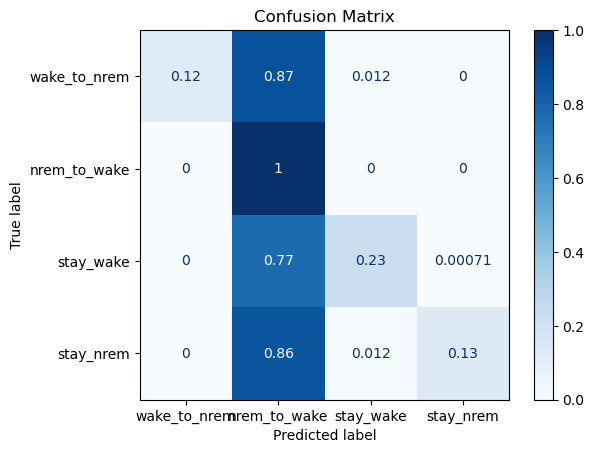

In [15]:
window_size=5
test_size=0.2
random_state=42
animal = None

split = processor.create_balanced_splits(
    split_type='inductive',
    label_type='multiclass',
    test_size=test_size,
    animal=animal,
    random_state=random_state,
    stratify=True
)

X_train, X_test = split['X_train'], split['X_test']
y_train, y_test = split['y_train'], split['y_test']


# Handle class imbalance - calculate scale_pos_weight
n_negative = (y_train == 0).sum()
n_positive = (y_train == 1).sum()
scale_pos_weight = n_negative / n_positive if n_positive > 0 else 1.0

# Train XGBoost model
xgb_params = {
    'objective': 'multi:softmax',
    'eval_metric': 'logloss',
    'random_state': random_state,
    **best_params
}
xgb_params = random_search.best_params_
# Create and train model
model = xgb.XGBClassifier(**xgb_params)

# Train with early stopping
model.fit(
    X_train, y_train,
    verbose=False
)


# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = balanced_accuracy_score(y_test, y_pred)
try:
    auc_score = roc_auc_score(y_test, y_pred_proba)
except ValueError:
    auc_score = np.nan  # Handle case where only one class in test set

print(f"   Test Balanced Accuracy: {accuracy:.4f}")
print(f"   Test AUC: {auc_score:.4f}")
print()


label_dict = {0:'wake_to_nrem', 1:'nrem_to_wake', 2:'stay_wake', 3:'stay_nrem'}
labels = sorted(label_dict.keys())
label_names = [label_dict[l] for l in labels]
# 'multiclass_raw': multiclass_labels,  # wake_to_nrem, nrem_to_wake, stay_wake, stay_nrem
# 'multiclass_encoded': multiclass_encoded,  # 0, 1, 2, 3

# Compute confusion matrix
#labels =  ['No Transition', 'Transition']
cm = confusion_matrix(y_test, y_pred, normalize='true', labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()



Top 20 Features by Importance:
                   Feature  Importance
141           in_deg_l1_t3    0.081715
142          out_deg_l1_t3    0.062235
138              spg_l1_t3    0.037377
169           eigent_l0_t4    0.022757
162                  cv_t4    0.022708
194           in_deg_l2_t4    0.019506
145           avg_path1_t3    0.018915
382   in_deg_l2_first_diff    0.014825
155          out_deg_l2_t3    0.014190
160                 rho_t4    0.013676
181           in_deg_l1_t4    0.013309
187             maxe_l2_t4    0.012833
149             sece_l2_t3    0.011970
343   in_deg_l1_first_diff    0.011924
122                  cv_t3    0.011761
346  out_deg_l1_first_diff    0.011580
147             maxe_l2_t3    0.011420
125             sece_l0_t3    0.010669
174             maxe_l1_t4    0.010147
89            eigent_l0_t2    0.009706


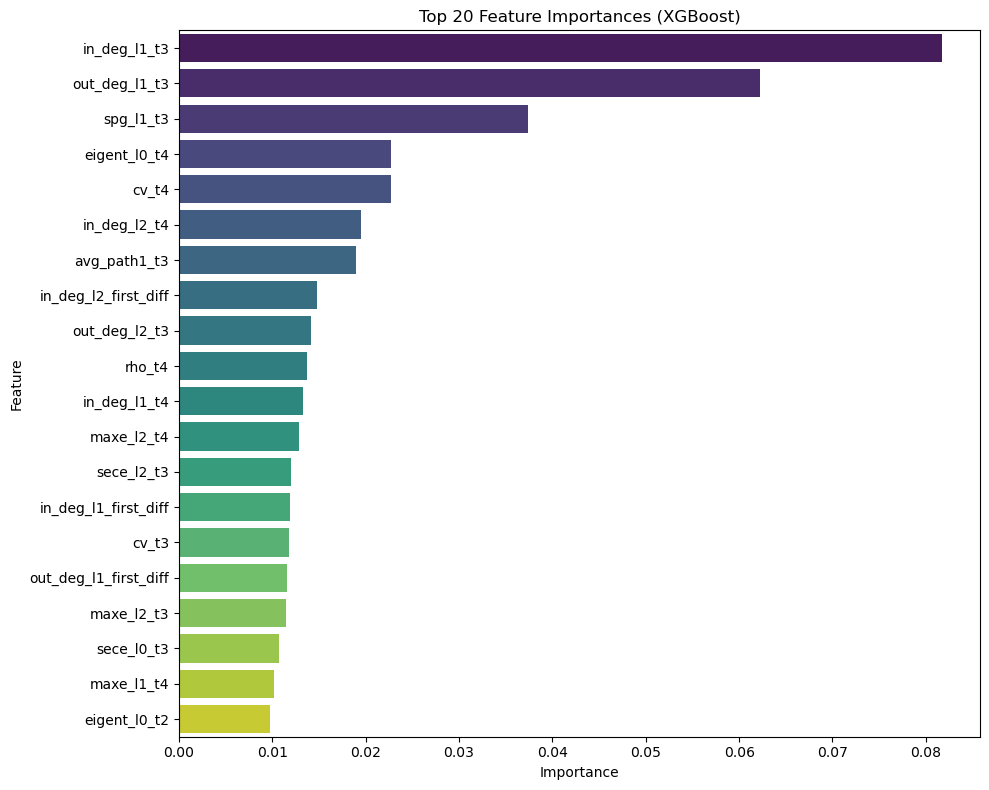

In [16]:
# Build dataframe of feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

# Show top features
print("\nTop 20 Features by Importance:")
print(feature_importance.head(20))

# Plot top 20
plt.figure(figsize=(10, 8))
sns.barplot(
    data=feature_importance.head(20),
    x='Importance',
    y='Feature',
    palette='viridis'
)
plt.title("Top 20 Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
